# 2 Pre-procesamiento

In [1]:
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import es_core_news_sm # Modelo Spacy de procesamiento de lenguaje natural en español
import spacy # Biblioteca de procesamiento de lenguaje natural
import pandas as pd # Biblioteca de manejo de conjuntos de datos
import re # Módulo de expresiones regulares
import tokenizers # Biblioteca de tokenización de texto
import nltk # Biblioteca de procesamiento de lenguaje natural
from pathlib import Path # Biblioteca para manejo de paths relativos
import tqdm # Biblioteca que proporciona una barra de progreso para bucles y tareas iterativas en Python
import os # Módulo incorporado en Python que proporciona funciones para interactuar con el sistema operativo
import csv # Módulo incorporado en Python que proporciona funciones para leer y escribir archivos CSV

2023-06-08 02:52:38.728371: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 02:52:41.820927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 02:52:41.822371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 02:52:47.815516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path=Path('..')

## 🤗 Datasets

🤗 (HuggingFace) Datasets es una biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural que se destaca por la simplicidad de sus métodos y el gran repositorio 🤗 Hub que contiene muchos conjuntos de datos libres para descargar sólo con una linea de Python.

En nuestro curso trabajaremos con `spanish_diagnostics`, un conjunto de datos de nuestro grupo investigación PLN@CMM que contiene textos de sospechas diagnósticas de la lista de espera chilena y está etiquetado con el destino de la interconsulta; este destino puede ser `dental` o `no_dental`.

In [3]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Con esta linea descargamos el conjunto de datos completo

Found cached dataset spanish_diagnostics (/home/vscode/.cache/huggingface/datasets/fvillena___spanish_diagnostics/default/0.0.0/45c176cea64580ea9631f78c2867a657ede368597681e5337e9f1c976e4e84ff)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

In [5]:
spanish_diagnostics_normalized = spanish_diagnostics["train"].map(
    lambda x: { # Utilizamos una función anónima que devuelve un diccionario
        "normalized_text" : normalize(x["text"]) # Esta es una nueva característica que agregaremos a nuestro conjunto de datos.
    })

Loading cached processed dataset at /home/vscode/.cache/huggingface/datasets/fvillena___spanish_diagnostics/default/0.0.0/45c176cea64580ea9631f78c2867a657ede368597681e5337e9f1c976e4e84ff/cache-d5ca831a1f652e8c.arrow


In [6]:
spanish_diagnostics_normalized

Dataset({
    features: ['text', 'label', 'normalized_text'],
    num_rows: 70000
})

Ahora nuestro conjunto de datos cuenta con una nueva característica `normalized_text`.

In [7]:
spanish_diagnostics_normalized[0]

{'text': '- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'label': 1,
 'normalized_text': '  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar'}

## Tokenización

La tokenización es el proceso de demarcación de secciones de una cadena de caracteres. Estas secciones podrían ser oraciones, palabras o subpalabras.

El método más simple para tokenizar una cadena de caracteres en nuestro lenguaje es la separación por espacios. Aplicamos una separación por espacios mediante el método `str.split()` sobre nuestro conjunto de datos normalizado.

In [8]:
spanish_diagnostics_normalized[0]["normalized_text"]

'  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar'

In [9]:
spanish_diagnostics_normalized[0]["normalized_text"].split()

['anomalias',
 'dentofaciales',
 'incluso',
 'la',
 'maloclusion',
 'discrepancia',
 'dentomaxilar']

Si bien el método de separación por espacios funciona bien en nuestro conjunto de datos normalizado, también quisiéramos tokenizar nuestro texto sin normalizar.

In [10]:
spanish_diagnostics_normalized[0]["text"]

'- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR'

In [11]:
spanish_diagnostics_normalized[0]["text"].split()

['-',
 'ANOMALÍAS',
 'DENTOFACIALES',
 '(INCLUSO',
 'LA',
 'MALOCLUSIÓN)',
 'DISCREPANCIA',
 'DENTOMAXILAR']

Al aplicar el mismo métodos podemos observar que no funciona totalmente bien debido a la presencia de caracteres no alfabéticos. Para solucionar esto, existen métodos basados en una serie de reglas para solucionar estos problemas. Utilizaremos la implementación de un tokenizador basado en reglas de la biblioteca de procesamiento de lenguaje natural Spacy.

In [12]:
spacy_tokenizer = es_core_news_sm.load().tokenizer

In [13]:
list(spacy_tokenizer(spanish_diagnostics_normalized[0]["text"]))

[-,
 ANOMALÍAS,
 DENTOFACIALES,
 (,
 INCLUSO,
 LA,
 MALOCLUSIÓN,
 ),
 
 
 
  ,
 DISCREPANCIA,
 DENTOMAXILAR]

Al utilizar el tokenizador basado en reglas, podemos tener resultados mucho mejores que los anteriores.

### 🤗 Tokenizers

🤗 también cuenta con una biblioteca llamada Tokenizers, con la cual podemos construir nuestro tokenizador basado en nuestro conjunto de datos.

Instanciamos el tokenizador con un modelo WordPiece, el cual parte construyendo un vocabulario que incluye todas los caracteres presentes en el conjunto de datos y posteriormente comienza a mezclar caracteres hasta encontrar conjuntos de caracteres que tienen más probabilidad de aparecer juntos que separados.

In [14]:
tokenizer = tokenizers.Tokenizer(tokenizers.models.WordPiece())

Esta biblioteca nos permite añadir pasos de normalización directamente. Replicamos lo mismo que hacemos con nuestra función `normalizer()`.

In [15]:
normalizer = tokenizers.normalizers.Sequence([
    tokenizers.normalizers.Lowercase(), # Llevamos todo a minúscula
    tokenizers.normalizers.NFD(), # Separamos cada caracter según los elementos que lo componen: á -> (a, ´)
    tokenizers.normalizers.StripAccents(), # Eliminamos todos los acentos
    tokenizers.normalizers.Replace(tokenizers.Regex(r"[^a-z ]"), " ") # Reemplazamos todos los caracteres no alfabéticos
])

In [16]:
normalizer.normalize_str(spanish_diagnostics_normalized[0]["text"])

'  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar'

Añadimos el normalizador al tokenizador

In [17]:
tokenizer.normalizer = normalizer

Pre tokenizamos nuestro conjunto de datos mediante espacio para delimitar el tamaño que puede tener cada token.

In [18]:
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

Instanciamos el entrenador que entrenará nuestro tokenizador.

In [19]:
trainer = tokenizers.trainers.WordPieceTrainer()

Entrenamos el tokenizador sobre nuestro conjunto de datos.

In [20]:
tokenizer.train_from_iterator(spanish_diagnostics_normalized["text"], trainer)

Mediante el método `Tokenizer.encode()` obtenemos la representación tokenizada de nuesto texto. Esta representación contiene varios atributos, donde los más interesantes son:

- `ids`: Contiene nuestro texto representado a través de una lista que contiene los identificadores de cada token.
- `tokens`: Contiene nuestro texto representado a través de una lista que contiene el texto de cada token.

In [25]:
spanish_diagnostics_normalized[0]["text"]

'- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR'

In [26]:
tokenized_output = tokenizer.encode(spanish_diagnostics_normalized[0]["text"])

In [27]:
tokenized_output.ids

[383, 618, 635, 119, 466, 1765, 970]

In [28]:
tokenized_output.tokens

['anomalias',
 'dentofaciales',
 'incluso',
 'la',
 'maloclusion',
 'discrepancia',
 'dentomaxilar']

Tal como lo hicimos anteriormente podemos aplicar paralelamente nuestro tokenizador sobre el conjunto de datos mediante el método `Dataset.map()`

In [30]:
spanish_diagnostics_normalized_tokenized = spanish_diagnostics_normalized.map(lambda x: {"tokenized_text":tokenizer.encode(x["text"]).tokens})

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Nuestro conjunto de datos ahora contiene el texto tokenizado en la característica `tokenized_text`.

In [31]:
spanish_diagnostics_normalized_tokenized[0]

{'text': '- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'label': 1,
 'normalized_text': '  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar',
 'tokenized_text': ['anomalias',
  'dentofaciales',
  'incluso',
  'la',
  'maloclusion',
  'discrepancia',
  'dentomaxilar']}

## Stemming y Lematización

Con el fin de disminuir la cantidad de características de las representaciones de texto existen métodos que reducen el tamaño de vocabulario al eliminar inflexiones que puedan tener las palabras. Estos métodos son:

- Lematización: Este método lleva una palabra en su forma flexionada a su forma base, por ejemplo *tratada* -> *tratar*
- Stemming: Este método trunca las palabras de entrada mediante un algoritmo predefinido para encontrar la raíz de la misma, por ejemplo *tratada* -> *trat*

El proceso de lematización lo haremos a través de la biblioteca Spacy y el proceso de stemming a través de la biblioteca NLTK utilizando el algoritmo Snowball.

Instanciamos el analizador de Spacy

In [33]:
nlp = es_core_news_sm.load()

Definimos como tokenizador el que entrenamos anteriormente.

In [34]:
def custom_tokenizer(text):
    tokens = tokenizer.encode(text).tokens
    return spacy.tokens.Doc(nlp.vocab,tokens)

In [35]:
nlp.tokenizer = custom_tokenizer

Instanciamos el Stemmer

In [36]:
stemmer = nltk.stem.SnowballStemmer("spanish")

Podemos verificar cómo funcionan estos métodos sobre un texto de prueba de nuestro conjunto de datos.

In [37]:
for t in nlp(spanish_diagnostics_normalized_tokenized[5]["text"]):
    print(f"Token: {t.text}\nLema: {t.lemma_}\nStem: {stemmer.stem(t.text)}\n---")

Token: pieza
Lema: pieza
Stem: piez
---
Token: n
Lema: n
Stem: n
---
Token: tratada
Lema: tratado
Stem: trat
---
Token: endodonticamente
Lema: endodonticamente
Stem: endodont
---
Token: restaurada
Lema: restaurado
Stem: restaur
---
Token: con
Lema: con
Stem: con
---
Token: ionomero
Lema: ionomero
Stem: ionomer
---
Token: y
Lema: y
Stem: y
---
Token: resina
Lema: resina
Stem: resin
---
Token: compuesta
Lema: compuesto
Stem: compuest
---
Token: necesita
Lema: necesitar
Stem: necesit
---
Token: protesis
Lema: protesis
Stem: protesis
---
Token: fija
Lema: fijo
Stem: fij
---
Token: por
Lema: por
Stem: por
---
Token: gran
Lema: gran
Stem: gran
---
Token: pnrdida
Lema: pnrdida
Stem: pnrdid
---
Token: coronaria
Lema: coronario
Stem: coronari
---


# Pre-procesamiento con NLTK

En Python existe en "Natural Language Toolkit" que tiene un [libro asociado](http://www.nltk.org/book/). Ejemplos de tokenizadores mas comunes de la libreria (Natural Language Toolkit) :

- Whitespace tokenization: Este enfoque simple divide una cadena de texto en tokens utilizando los espacios en blanco como delimitadores. Cada palabra o elemento separado por espacios en blanco se considera un token. Por ejemplo, la cadena "Hola, ¿cómo estás?" se dividiría en los tokens "Hola,", "¿cómo" y "estás?".

- Punctuation-based tokenization: Este tokenizador se basa en los signos de puntuación para dividir una cadena de texto en tokens. Cada signo de puntuación se considera un token independiente. Por ejemplo, la cadena "¡Hola! ¿Cómo estás?" se dividiría en los tokens "¡", "Hola", "!", "¿", "Cómo" y "estás".

- Default/TreebankWordTokenizer: Este tokenizador se basa en las convenciones utilizadas en el corpus de Treebank del Penn Treebank. Divide una cadena de texto en tokens siguiendo reglas específicas, como separar los signos de puntuación adyacentes de las palabras. Por ejemplo, la cadena "I can't go" se dividiría en los tokens "I", "ca", "n't" y "go".

- TweetTokenizer: Este tokenizador está diseñado específicamente para manejar texto de redes sociales, como tweets. Tiene en cuenta las convenciones y peculiaridades del lenguaje utilizado en las redes sociales, como hashtags, menciones de usuarios, emoticones, etc. Por ejemplo, la cadena "I love #NLTK!" se dividiría en los tokens "I", "love", "#NLTK" y "! ".

- MWETokenizer: Este tokenizador se utiliza para identificar y tratar expresiones compuestas por múltiples palabras como un solo token. Por ejemplo, en lugar de dividir la expresión "New York City" en tres tokens separados, este tokenizador la mantendría intacta como un único token.

[![medium](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*5385R1NI5mNm2J4WSlXo6A.png)](https://towardsdatascience.com/top-5-word-tokenizers-that-every-nlp-data-scientist-should-know-45cc31f8e8b9)

In [1]:
import nltk

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
nltk.download(['punkt','wordnet','gutenberg','webtext','stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ville\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ville\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\ville\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\ville\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

## Tokens 

In [41]:
#nltk.download(['punkt','wordnet','gutenberg','webtext','stopwords'])

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package webtext to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [39]:
example = "Hola! Como están? Después de esta clase yo me voy a mi casa"

In [42]:
print(sent_tokenize(example))

['Hola!', 'Como están?', 'Después de esta clase yo me voy a mi casa']


In [43]:
print(word_tokenize(example))

['Hola', '!', 'Como', 'están', '?', 'Después', 'de', 'esta', 'clase', 'yo', 'me', 'voy', 'a', 'mi', 'casa']


## Stopwords

In [44]:
from nltk.corpus import stopwords

In [45]:
stop_words= set(stopwords.words('spanish'))

In [46]:
wordTokens = word_tokenize(example)
print(wordTokens)

['Hola', '!', 'Como', 'están', '?', 'Después', 'de', 'esta', 'clase', 'yo', 'me', 'voy', 'a', 'mi', 'casa']


In [47]:
filtered = [w for w in wordTokens if not w in stop_words]
print(filtered)

['Hola', '!', 'Como', '?', 'Después', 'clase', 'voy', 'casa']


## Stemming vs. lemmatization (English) 

In [48]:
from nltk.stem import PorterStemmer 
ps = PorterStemmer()

In [49]:
exampleWords = ["love", "Loving","loved", "lovelii"]

In [50]:
for w in exampleWords:
    print(ps.stem(w))

love
love
love
lovelii


Lemmatization

In [51]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [52]:
for w in exampleWords:
    print(lemmatizer.lemmatize(w))

love
Loving
loved
lovelii


In [53]:
# It seems it didn't work! It just copied the words!

## WordNet

WordNet es un diccionario léxico que organiza las palabras en grupos de sinónimos llamados "synsets" (conjuntos de sinónimos). Cada synset representa un concepto léxico y contiene una lista de palabras o frases que son intercambiables en ciertos contextos. Además de los sinónimos, WordNet también proporciona información semántica sobre las relaciones entre los synsets, como hiperónimos (conceptos más generales) e hipónimos (conceptos más específicos).

In [54]:
from nltk.corpus import wordnet

In [55]:
syns = wordnet.synsets("program")

In [56]:
print(syns[0].name())

plan.n.01


In [57]:
print(syns[0].lemmas()[0].name())

plan


In [58]:
print(syns[0].definition())

a series of steps to be carried out or goals to be accomplished


In [59]:
print(syns[0].examples())

['they drew up a six-step plan', 'they discussed plans for a new bond issue']


In [60]:
synonyms = []
antonyms = []

for syn in wordnet.synsets("good"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())

print(set(synonyms))

{'upright', 'soundly', 'good', 'full', 'skillful', 'adept', 'secure', 'undecomposed', 'right', 'goodness', 'beneficial', 'sound', 'honorable', 'expert', 'dear', 'proficient', 'well', 'just', 'in_effect', 'ripe', 'salutary', 'unspoilt', 'thoroughly', 'practiced', 'trade_good', 'commodity', 'effective', 'unspoiled', 'serious', 'estimable', 'honest', 'safe', 'in_force', 'dependable', 'skilful', 'respectable', 'near'}


In [61]:
print(set(antonyms))

{'badness', 'evilness', 'bad', 'ill', 'evil'}


## Corpora

El proyecto Gutenberg tiene libros en español http://www.gutenberg.org/ebooks/search/?query=spanish
Y pueden seguir estos pasos para bajar libros automáticamente: https://pypi.org/project/Gutenberg/

Hay muchos tutoriales en internet para aprender a usar NLTK, por ejemplo este: https://vprusso.github.io/blog/2018/natural-language-processing-python-1/

In [62]:
print(nltk.corpus.gutenberg.fileids())


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [63]:
from nltk.text import Text
macbeth = Text(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))

In [64]:
#palabras
print(len(macbeth)) 


23140


In [68]:
#oraciones
print(len(set(macbeth))) 

4017


In [69]:
macbeth.concordance("father")

Displaying 16 of 16 matches:
isse ' em . Had he not resembled My Father as he slept , I had don ' t . My Hu
e of it is stopt Macd . Your Royall Father ' s murther ' d Mal . Oh , by whom 
d former knowings Rosse . Ha , good Father , Thou seest the Heauens , as troub
ier then our new Rosse . Farewell , Father Old M . Gods benyson go with you , 
 my selfe should be the Roote , and Father Of many Kings . If there come truth
 Prophet - like , They hayl ' d him Father to a Line of Kings . Vpon my Head t
or Donalbane To kill their gracious Father ? Damned Fact , How it did greeue M
should finde What ' twere to kill a Father : So should Fleans . But peace ; fo
y Cosine , Blessing vpon you Wife . Father ' d he is , And yet hee ' s Father 
 Father ' d he is , And yet hee ' s Father - lesse Rosse . I am so much a Fool
ore Birds they are not set for : My Father is not dead for all your saying Wif
he is dead : How wilt thou do for a Father ? Son . Nay how will you do for a H
th wit enough for thee 

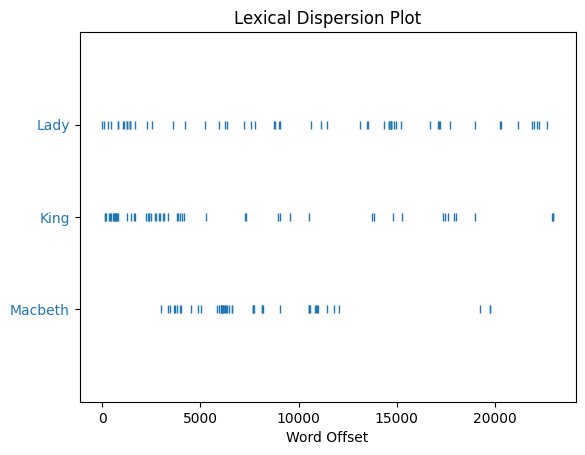

In [70]:
macbeth.dispersion_plot(["Macbeth", "King", "Lady"])

## Contar palabras 

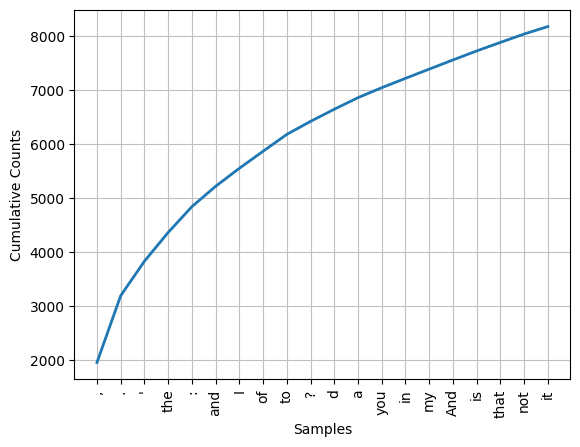

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [71]:
fdist = nltk.FreqDist(macbeth)
fdist.plot(20, cumulative=True)

Eliminando caracteres no alfabéticos

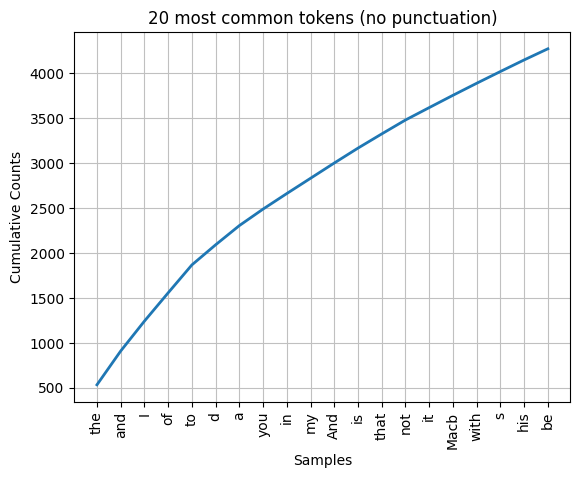

<Axes: title={'center': '20 most common tokens (no punctuation)'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [72]:
fdist_no_punc = nltk.FreqDist(dict((word, freq) for word, freq in fdist.items() if word.isalpha()))
fdist_no_punc.plot(20, cumulative=True, title="20 most common tokens (no punctuation)")

Eliminando _stopwords_

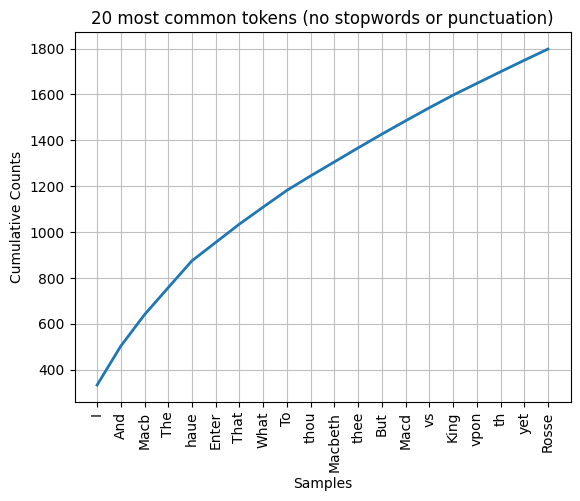

<Axes: title={'center': '20 most common tokens (no stopwords or punctuation)'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [73]:
stopwords = nltk.corpus.stopwords.words('english')
fdist_no_punc_no_stopwords = nltk.FreqDist(dict((word, freq) for word, freq in fdist.items() if word not in stopwords and word.isalpha()))
fdist_no_punc_no_stopwords.plot(20, cumulative=True, title="20 most common tokens (no stopwords or punctuation)")

## Nubes de palabras

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [35]:
text = "El curso de estadistica y  probabilidades para el análsis de datos está super bueno!"

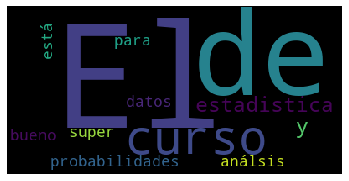

In [36]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Funcionó, pero igual es feo :P

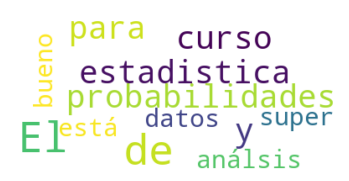

In [37]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Y se pueden hacer nubes con formas también: https://www.datacamp.com/community/tutorials/wordcloud-python.
Estas nubes son más interesantes con textos más grandes. 

In [38]:
macbeth

<Text: The Tragedie of Macbeth by William Shakespeare 1603>

In [39]:
palabras = nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')
palabras

"[The Tragedie of Macbeth by William Shakespeare 1603]\n\n\nActus Primus. Scoena Prima.\n\nThunder and Lightning. Enter three Witches.\n\n  1. When shall we three meet againe?\nIn Thunder, Lightning, or in Raine?\n  2. When the Hurley-burley's done,\nWhen the Battaile's lost, and wonne\n\n   3. That will be ere the set of Sunne\n\n   1. Where the place?\n  2. Vpon the Heath\n\n   3. There to meet with Macbeth\n\n   1. I come, Gray-Malkin\n\n   All. Padock calls anon: faire is foule, and foule is faire,\nHouer through the fogge and filthie ayre.\n\nExeunt.\n\n\nScena Secunda.\n\nAlarum within. Enter King Malcome, Donalbaine, Lenox, with\nattendants,\nmeeting a bleeding Captaine.\n\n  King. What bloody man is that? he can report,\nAs seemeth by his plight, of the Reuolt\nThe newest state\n\n   Mal. This is the Serieant,\nWho like a good and hardie Souldier fought\n'Gainst my Captiuitie: Haile braue friend;\nSay to the King, the knowledge of the Broyle,\nAs thou didst leaue it\n\n   Cap. 

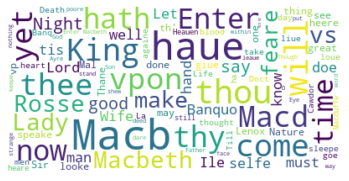

In [40]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(palabras)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Y no sólo hay libros! 

In [41]:
for file_id in nltk.corpus.webtext.fileids():
    print(file_id) 

firefox.txt
grail.txt
overheard.txt
pirates.txt
singles.txt
wine.txt
